# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
import training
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import config
import PNN_Setting as ps
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_Seeds.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([210, 7]), torch.Size([210]), 210, 7, 3)

## data preprocessing

In [3]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))

random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test-E_valid])

len(train_data), len(valid_data), len(test_data)

(126, 42, 42)

In [5]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Definite PNN and AgingAwarePNN

In [6]:
N_Hidden = 4
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_class, age_generator))
M_train = 10
K_train = 5
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.5 / M_train / K_train)
AAPNN

AttributeError: module 'torch' has no attribute 'theta'

In [ ]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

In [ ]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class))

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
celoss = torch.nn.CrossEntropyLoss()
NN

# Normal NN

In [9]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(200)):
    for x_train, y_train in train_loader:
        optimizer_NN.zero_grad()
        prediction = NN(x_train)
        loss = celoss(prediction, y_train)
        loss.backward()
        optimizer_NN.step()

    for x_valid, y_valid in valid_loader:
        prediction_valid = NN(x_valid)
        y_hat = torch.argmax(prediction_valid, 1).data.numpy().squeeze()
        acc_valid = sum(y_hat == y_valid.numpy()) / y_valid.shape[0]
        loss_valid = celoss(prediction_valid, y_valid)
    if epoch % 10 == 0:
        print(f'| Epoch: {epoch:-5d} | Accuracy: {acc_valid:.5f} | Loss: {loss_valid.data:.5f} |')

  0%|          | 0/200 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.23810 | Loss: 1.12948 |
| Epoch:    10 | Accuracy: 0.47619 | Loss: 1.08755 |
| Epoch:    20 | Accuracy: 0.64286 | Loss: 1.04019 |
| Epoch:    30 | Accuracy: 0.71429 | Loss: 0.98173 |
| Epoch:    40 | Accuracy: 0.71429 | Loss: 0.91402 |
| Epoch:    50 | Accuracy: 0.76190 | Loss: 0.84079 |
| Epoch:    60 | Accuracy: 0.85714 | Loss: 0.76649 |
| Epoch:    70 | Accuracy: 0.88095 | Loss: 0.69544 |
| Epoch:    80 | Accuracy: 0.88095 | Loss: 0.63061 |
| Epoch:    90 | Accuracy: 0.88095 | Loss: 0.57338 |
| Epoch:   100 | Accuracy: 0.88095 | Loss: 0.52388 |
| Epoch:   110 | Accuracy: 0.88095 | Loss: 0.48145 |
| Epoch:   120 | Accuracy: 0.88095 | Loss: 0.44523 |
| Epoch:   130 | Accuracy: 0.90476 | Loss: 0.41437 |
| Epoch:   140 | Accuracy: 0.90476 | Loss: 0.38808 |
| Epoch:   150 | Accuracy: 0.90476 | Loss: 0.36568 |
| Epoch:   160 | Accuracy: 0.90476 | Loss: 0.34659 |
| Epoch:   170 | Accuracy: 0.90476 | Loss: 0.33030 |
| Epoch:   180 | Accuracy: 0.90476 | Loss: 0.3

# Normal PNN

## Train

In [10]:
m = 0.3
T = 0.1
train_loss_PNN, valid_loss_PNN, parameter_PNN = training.train_normal_pnn(PNN,
                                                                         train_loader, valid_loader,
                                                                         m, T, optimizer_PNN, pnn.LossFunction,
                                                                         Epoch=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33333 | Loss: 1.202274692 |
| Epoch:   100 | Accuracy: 0.83333 | Loss: 0.310381655 |
| Epoch:   200 | Accuracy: 0.88095 | Loss: 0.198934301 |
| Epoch:   300 | Accuracy: 0.88095 | Loss: 0.168868869 |
| Epoch:   400 | Accuracy: 0.92857 | Loss: 0.156342488 |
| Epoch:   500 | Accuracy: 0.92857 | Loss: 0.152900302 |
| Epoch:   600 | Accuracy: 0.95238 | Loss: 0.146881861 |
| Epoch:   700 | Accuracy: 0.95238 | Loss: 0.136278826 |
| Epoch:   800 | Accuracy: 0.95238 | Loss: 0.125974052 |
| Epoch:   900 | Accuracy: 0.95238 | Loss: 0.115519491 |
Finished.


## Early Stop

tensor(0.0918, dtype=torch.float64)

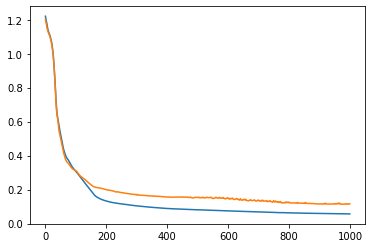

In [11]:
plt.plot(train_loss_PNN, label='train')
plt.plot(valid_loss_PNN, label='valid')

PNN.load_state_dict(parameter_PNN)

for x_test, y_test in test_loader:
    prediction_test = PNN(x_test)
    loss_test = pnn.LossFunction(prediction_test, y_test, m, T)
loss_test.data

# Aging Aware PNN with Model Variation

## Train

In [12]:
importlib.reload(training)

valid_loss_AAPNN, parameter_AAPNN = training.train_aged_pnn(AAPNN,
                                                           train_loader, valid_loader,
                                                           config.m, config.T, M_train, K_train,
                                                            20, 10, optimizer_AAPNN,
                                                           pnn.LossFunction, Epoch=500)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33107 | Loss: 1.284101314 |
| Epoch:    10 | Accuracy: 0.32488 | Loss: 1.242642413 |
| Epoch:    20 | Accuracy: 0.34917 | Loss: 1.184421815 |
| Epoch:    30 | Accuracy: 0.34429 | Loss: 1.123549101 |
| Epoch:    40 | Accuracy: 0.44143 | Loss: 1.042151830 |
| Epoch:    50 | Accuracy: 0.53476 | Loss: 0.896185856 |
| Epoch:    60 | Accuracy: 0.58107 | Loss: 0.836451434 |
| Epoch:    70 | Accuracy: 0.61429 | Loss: 0.787120346 |
| Epoch:    80 | Accuracy: 0.59024 | Loss: 0.757618704 |
| Epoch:    90 | Accuracy: 0.68774 | Loss: 0.702396919 |
| Epoch:   100 | Accuracy: 0.67500 | Loss: 0.651545073 |
| Epoch:   110 | Accuracy: 0.73548 | Loss: 0.580583736 |
| Epoch:   120 | Accuracy: 0.77821 | Loss: 0.463969726 |
| Epoch:   130 | Accuracy: 0.76869 | Loss: 0.469025833 |
| Epoch:   140 | Accuracy: 0.80762 | Loss: 0.423233223 |
| Epoch:   150 | Accuracy: 0.81202 | Loss: 0.397058345 |
| Epoch:   160 | Accuracy: 0.83726 | Loss: 0.361731750 |
| Epoch:   170 | Accuracy: 0.83

## Early Stop

<All keys matched successfully>

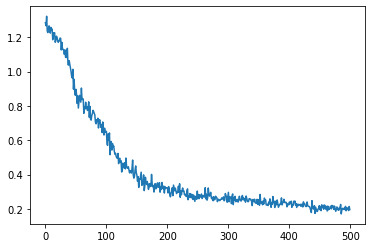

In [13]:
plt.plot(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)

# Save and Read

In [14]:
# torch.save(MyPNN, f'./simpleclassification/MyPNN_{N_Layer}_{N_Hidden}.pkl')
# torch.save(MyAgedPNN, f'./simpleclassification/MyAgedPNN_{N_Layer}_{N_Hidden}.pkl')

In [15]:
# MyPNN = torch.load('/simpleclassification/MyPNN.pkl')
# MyAgedPNN = torch.load('/simpleclassification/MyAgedPNN.pkl')

# Evaluation
Evaluate two pNNs with $M_{test}$ different aging models and $K_{test}$ timings.

## Test

In [16]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0, 1, config.K_test)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for omega in range(config.M_test):
    AAPNN.apply(ps.makemodel)
    PNN.apply(ps.makemodel)
    for test_t in test_time:
        AAPNN.apply(lambda z: ps.settime(z, test_t))
        PNN.apply(lambda z: ps.settime(z, test_t))

        my_aged_acc.append(evaluation.BASIC(AAPNN, x_test, y_test))
        my_acc.append(evaluation.BASIC(PNN, x_test, y_test))

        my_aged_maa.append(evaluation.MAA(AAPNN, x_test, y_test))
        my_maa.append(evaluation.MAA(PNN, x_test, y_test))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

In [17]:
my_acc = np.array(my_acc).reshape([config.M_test, config.K_test])
my_aged_acc = np.array(my_aged_acc).reshape([config.M_test, config.K_test])

mean_acc = np.mean(my_acc, axis=0).flatten()
mean_aged_acc = np.mean(my_aged_acc, axis=0).flatten()

std_acc = np.std(my_acc, axis=0).flatten()
std_aged_acc = np.std(my_aged_acc, axis=0).flatten()

## Visualization

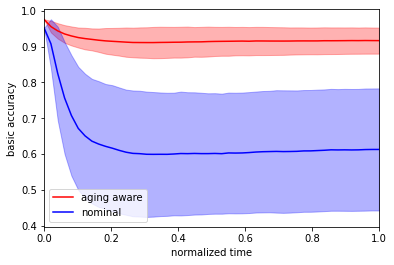

In [18]:
plt.fill_between(test_time, mean_aged_acc-std_aged_acc,
                 mean_aged_acc+std_aged_acc, alpha=0.3, color='red')
plt.fill_between(test_time, mean_acc-std_acc, mean_acc +
                 std_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_acc, label='aging aware', color='red')
plt.plot(test_time, mean_acc, label='nominal', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

In [19]:
my_maa = np.array(my_maa).reshape([config.M_test, config.K_test])
my_aged_maa = np.array(my_aged_maa).reshape([config.M_test, config.K_test])

mean_maa = np.mean(my_maa, axis=0).flatten()
mean_aged_maa = np.mean(my_aged_maa, axis=0).flatten()

std_maa = np.std(my_maa, axis=0).flatten()
std_aged_maa = np.std(my_aged_maa, axis=0).flatten()

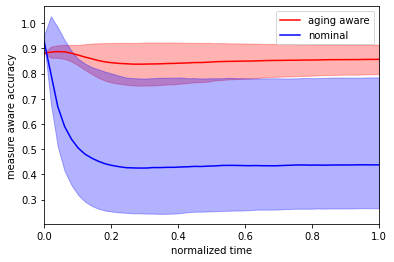

In [20]:
plt.fill_between(test_time, mean_aged_maa-std_aged_maa,
                 mean_aged_maa+std_aged_maa, alpha=0.3, color='red')
plt.fill_between(test_time, mean_maa-std_maa, mean_acc +
                 std_maa, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_maa, label='aging aware', color='red')
plt.plot(test_time, mean_maa, label='nominal', color='blue')
plt.xlabel('normalized time')
plt.ylabel('measure aware accuracy')
plt.xlim([0, 1])
plt.legend()